# hand-sign recognizer
Here we build a deep neural-network for recognizing hand-signs.

> Inspired by: [Improving Deep Neural Networks: Hyperparameter Tuning, Regularization and Optimization](https://www.coursera.org/learn/deep-neural-network?specialization=deep-learning)

In [10]:
import torch
import h5py
import numpy as np
from numpy.random import default_rng
from tqdm import tqdm
from matplotlib import pyplot as plt

if torch.cuda.is_available(): # TODO: remove the false
    print("Cuda available.")
    tensor_type = 'torch.cuda.DoubleTensor'
    torch.backends.cuda.matmul.allow_tf32 = True
else:
    print("Cuda not found.")
    tensor_type = 'torch.DoubleTensor'

print(f"Setting {tensor_type} as default dtype...")
torch.set_default_tensor_type(tensor_type)

Cuda available.
Setting torch.cuda.DoubleTensor as default dtype...


In [11]:
train_x, train_y, test_x, test_y, class_labels = None, None, None, None, None
with h5py.File("../data/train-hand-signs.h5", "r") as f:
    train_x = np.array(f["train_set_x"])
    train_y = np.array(f["train_set_y"])

with h5py.File("../data/test-hand-signs.h5", "r") as f:
    test_x = np.array(f["test_set_x"])
    test_y = np.array(f["test_set_y"])
    class_labels = np.array(f["list_classes"])

print(f"# of training-examples: {train_x.shape[0]}")
print(f"# of test-examples: {test_x.shape[0]}")
print(f"image-dimensions: {test_x.shape[1:]}")
print(f"class-labels: {class_labels}")

# of training-examples: 1080
# of test-examples: 120
image-dimensions: (64, 64, 3)
class-labels: [0 1 2 3 4 5]


## # pre-processing
We will pre-process the images as follows:
 - Flatten each image from (64, 64, 3) array to a (64 * 64 * 3, 1) array
 - Convert the class-labels to one-hot vectors
 - Mean and variance normalize the inputs

In [12]:
train_X = train_x.reshape((train_x.shape[0], -1)).copy().T
train_Y = np.eye(len(class_labels))[train_y].copy().T

# train-set normalization
train_mean = np.mean(train_X, axis=1)
train_mean = np.reshape(train_mean, (train_mean.shape[0], 1))
train_std = np.std(train_X, axis=1)
train_std = np.reshape(train_std, (train_std.shape[0], 1))

train_X = (train_X - train_mean) / train_std

# test-set normalization
test_X = test_x.reshape((test_x.shape[0], -1)).copy().T
test_Y = np.eye(len(class_labels))[test_y].copy().T
test_X = (test_X - train_mean) / train_std

print(f"Train-set X: {train_X.shape}, Y: {train_Y.shape}")
print(f"Test-set X: {test_X.shape}, Y: {test_Y.shape}")

cu_train_X = torch.tensor(train_X)
cu_train_Y = torch.tensor(train_Y)
cu_test_X = torch.tensor(test_X)
cu_test_Y = torch.tensor(test_Y)

Train-set X: (12288, 1080), Y: (6, 1080)
Test-set X: (12288, 120), Y: (6, 120)


## # architecture
We will use a 3-layer neural-network, as defined below:

$$
\begin{align*}
& n^{[1]} = 25 && g^{[1]} = \text{ReLU} \\
& n^{[2]} = 12 && g^{[2]} = \text{ReLU} \\
& n^{[3]} = 6 && g^{[3]} = \text{Softmax} \\
\end{align*}
$$

$$
\begin{align*}
\text{where, } & n^{[l]} \text{ is the size of layer-$l$} \\
& g^{[l]} \text{ is the activation of layer-$l$}
\end{align*}
$$

## # forward-propagation
The equation for forward-propagation are as follows:

$$
\begin{aligned}
\mathbf{Z}^{[l]} & = (\mathbf{W}^{[l]})^\intercal \mathbf{A}^{[l-1]} + \mathbf{b}^{[l]}\vec{1}_{(1,m)} \\
\mathbf{A}^{[l]} & = f_{activation}(\mathbf{Z}^{[l]})\\
\mathbf{L}(\hat{\mathbf{y}}, \mathbf{y}) & = -\biggl[\sum_{i=1}^{n^{[L]}} y^{(1)}_{i} \log(\hat{y}^{(1)}_i), \sum_{i=1}^{n^{[L]}} y^{(2)}_{i} \log(\hat{y}^{(2)}_i), \dots, \sum_{i=1}^{n^{[L]}} y^{(m)}_{i} \log(\hat{y}^{(m)}_i) \biggr] \\
J & = \frac{1}{m}\sum_{i = 1}^{m}L(\hat{y}^{(i)}, y^{(i)})  = \frac{1}{m}\mathbf{L}\vec{1}_{(m,1)} \\
& = \frac{-1}{m} \sum_{j=1}^{m} \biggl[\sum_{i=1}^{n^{[L]}} y^{(j)}_{i} \log(\hat{y}^{(j)}_i) \biggr] \\
\end{aligned}
$$

\begin{align*}
\text{where, } & m && \text{is the number of training-examples} \\
& L && \text{is the number of layers, i.e. network-depth} \\
& \mathbf{W}^{[l]} &&\text{is a $(n^{[l-1]}, n^{[l]})$ dimensional Weight-matrix}\\
& \mathbf{A}^{[l-1]} &&\text{is a $(n^{[l-1]}, m)$ dimensional activation-vector; and, }\mathbf{A}^{[0]} = \mathbf{X} \\
& \mathbf{b}^{[l]} &&\text{is a $(n^{[l]}, 1)$ dimensional bias-vector} \\
& \vec{1}_{(1,m)} && \text{is a $(1, m)$ dimensional vector of all 1's.} \\
& &&\text{Multiplying this with $ \mathbf{b}^{[l]}$ has the same effect as python's broadcasting.} \\
& f_{activation}() &&\text{is ReLU for all hidden-layers; is Sigmoid for the output-layer} \\
& \hat{\mathbf{y}} && = \mathbf{A}^{[L]}\text{ is a $(n^{[L]},m)$-dimensional result of the output-layer} \\
& \mathbf{L} &&\text{is the cross-entropy loss-function, and is a $(1,m)$ row vector}\\
& J && \text{is the cross-entropy cost-function}
\end{align*}

In [13]:
def sigmoid(Z: torch.Tensor) -> torch.Tensor:
    return 1 / (1 + torch.exp(-Z))

def relu(Z: torch.Tensor) -> torch.Tensor:
    return torch.maximum(Z, torch.tensor(0))

sftmx = torch.nn.Softmax(dim=0)
def softmax(Z: torch.Tensor) -> torch.Tensor:
    return sftmx(Z)

def linear(W: torch.Tensor, A: torch.Tensor, b: torch.Tensor) -> torch.Tensor:
    return torch.matmul(W.T, A) + b

def activation(Zl: torch.Tensor, func_name: str) -> torch.Tensor:
    if func_name == 'sigmoid':
        return sigmoid(Zl)
    elif func_name == 'relu':
        return relu(Zl)
    elif func_name == 'softmax':
        return softmax(Zl)
    else:
        raise ValueError(f"Unknown activation-function: {func_name}")

def forward_propogate(X: torch.Tensor, model: dict) -> tuple:
    L: int = model["L"]
    
    cache = {'m': X.shape[1], 'c-l0': (X, None, None, None)}

    Al_1 = X
    Al = None
    for l in range(L):
        Wl = model['W-l' + str(l + 1)]
        bl = model['b-l' + str(l + 1)]
        Zl = linear(Wl, Al_1, bl)
        Al = activation(Zl, model['g-l' + str(l + 1)])
        cache['c-l' + str(l + 1)] = (Al.clone(), Wl.clone(), bl.clone(), Zl.clone())
        
        Al_1 = Al
    
    return Al, cache

def softmax_cost(Al: torch.Tensor, Y: torch.Tensor, **kwargs) -> float:
    """
    Assumes Y and Al to be (nl,m) dimensional vectors
    """
    assert Al.shape == Y.shape

    return torch.multiply(-Y, torch.log(Al)).sum() / Al.shape[1]

 
## # backward-propagation
The following jacobians are obtained througn back-propagation are jacobians:

$$
\begin{aligned}
& \frac{\mathrm{d}J}{\mathrm{d}\mathbf{Z}^{[l]}} && = \frac{\mathrm{d}J}{\mathrm{d}\mathbf{A}^{[l]}}\,\frac{\mathrm{d}\mathbf{A}^{[l]}}{\mathrm{d}\mathbf{Z}^{[l]}} \\
&\frac{\mathrm{d}J}{\mathrm{d}\mathbf{W}^{[l]}} && = \biggl(\frac{\mathrm{d}J}{\mathrm{d}\mathbf{Z}^{[l]}}\biggr)^\intercal (\mathbf{A}^{[l-1]})^\intercal  \\
&\frac{\mathrm{d}J}{\mathrm{d}\mathbf{b}^{[l]}} && = \vec{1}_{(1,m)} \frac{\mathrm{d}J}{\mathrm{d}\mathbf{Z}^{[l]}} \\
&\frac{\mathrm{d}J}{\mathrm{d}\mathbf{A}^{[l-1]}} && = \frac{\mathrm{d}J}{\mathrm{d}\mathbf{Z}^{[l]}} (\mathbf{W}^{[l]})^\intercal  \\
\end{aligned}
$$

And, the gradients are simply the transpose of these jacobians, i.e.

$$
\begin{aligned}
\nabla_{\mathbf{W}^{[l]}}\big(J\big) & = \bigg(\frac{\mathrm{d}J}{\mathrm{d}\mathbf{W}^{[l]}}\bigg)^\intercal && = \mathbf{A}^{[l-1]} \frac{\mathrm{d}J}{\mathrm{d}\mathbf{Z}^{[l]}} \\
\nabla_{\mathbf{b}^{[l]}}\big(J\big) & = \bigg(\frac{\mathrm{d}J}{\mathrm{d}\mathbf{b}^{[l]}}\bigg)^\intercal && = \biggl(\frac{\mathrm{d}J}{\mathrm{d}\mathbf{Z}^{[l]}}\biggr)^\intercal (\vec{1}_{(1,m)})^\intercal  \\
\end{aligned}
$$

> **Note**: For a detailed derivation of these equations, see and [`.\back-propagation.pdf`](back-propagation.pdf).

* When $l = L$ (i.e. the output-layer), we have

$$
\begin{align*}
\frac{\mathrm{d}J}{\mathrm{d}\mathbf{A}^{[L]}} & = \begin{bmatrix}
\frac{\partial}{\partial\mathrm{a^{[L](1)}_{1}}} & \frac{\partial}{\partial\mathrm{a^{[L](1)}_{2}}} & \dots & \frac{\partial}{\partial\mathrm{a^{[L](1)}_{n^{[L]}}}} \\
\frac{\partial}{\partial\mathrm{a^{[L](2)}_{1}}} & \frac{\partial}{\partial\mathrm{a^{[L](2)}_{2}}} & \dots & \frac{\partial}{\partial\mathrm{a^{[L](2)}_{n^{[L]}}}} \\
\vdots & \vdots & \ddots & \vdots \\
\frac{\partial}{\partial\mathrm{a^{[L](m)}_{1}}} & \frac{\partial}{\partial\mathrm{a^{[L](m)}_{2}}} & \dots & \frac{\partial}{\partial\mathrm{a^{[L](m)}_{n^{[L]}}}} \\
\end{bmatrix} \otimes J \\
& = \begin{bmatrix}
\frac{\partial J}{\partial\mathrm{a^{[L](1)}_{1}}} & \frac{\partial J}{\partial\mathrm{a^{[L](1)}_{2}}} & \dots & \frac{\partial J}{\partial\mathrm{a^{[L](1)}_{n^{[L]}}}} \\
\frac{\partial J}{\partial\mathrm{a^{[L](2)}_{1}}} & \frac{\partial J}{\partial\mathrm{a^{[L](2)}_{2}}} & \dots & \frac{\partial J}{\partial\mathrm{a^{[L](2)}_{n^{[L]}}}} \\
\vdots & \vdots & \ddots & \vdots \\
\frac{\partial J}{\partial\mathrm{a^{[L](m)}_{1}}} & \frac{\partial J}{\partial\mathrm{a^{[L](m)}_{2}}} & \dots & \frac{\partial J}{\partial\mathrm{a^{[L](m)}_{n^{[L]}}}} \\
\end{bmatrix}\\
& = \frac{-1}{m} \begin{bmatrix}
\frac{y^{(1)}_{1}}{\mathrm{a^{[L](1)}_{1}}} & \frac{y^{(1)}_{2}}{\mathrm{a^{[L](1)}_{2}}} & \dots & \frac{y^{(1)}_{n^{[L]}}}{\mathrm{a^{[L](1)}_{n^{[L]}}}} \\
\frac{y^{(2)}_{1}}{\mathrm{a^{[L](2)}_{1}}} & \frac{y^{(2)}_{2}}{\mathrm{a^{[L](2)}_{2}}} & \dots & \frac{y^{(2)}_{n^{[L]}}}{\mathrm{a^{[L](2)}_{n^{[L]}}}} \\
\vdots & \vdots & \ddots & \vdots \\
\frac{y^{(m)}_{1}}{\mathrm{a^{[L](m)}_{1}}} & \frac{y^{(m)}_{2}}{\mathrm{a^{[L](m)}_{2}}} & \dots & \frac{y^{(m)}_{n^{[L]}}}{\mathrm{a^{[L](m)}_{n^{[L]}}}} \\
\end{bmatrix}\\
& = \frac{-1}{m} (\mathbf{y} \oslash \mathbf{A}^{[L]})^\intercal \\
\newline
\text{where, } \oslash & \text{ is the hadamard-division, i.e. element-wise division}
\end{align*}
$$

* When $f_{activation} = $ `softmax`, we have

$$
\begin{aligned}
\qquad \frac{\mathrm{d}\mathbf{A}^{[l](i)}}{\mathrm{d}\mathbf{Z}^{[l](i)}} & = 
\begin{bmatrix}
\frac{\mathrm{d}}{\mathrm{d}z^{[l](i)}_{1}} & \frac{\mathrm{d}}{\mathrm{d}z^{[l](i)}_{2}} & \dots & \frac{\mathrm{d}}{\mathrm{d}z^{[l](i)}_{n^{[l]}}} \\
\end{bmatrix} \otimes \begin{bmatrix}
a^{[l](i)}_{1} \\
a^{[l](i)}_{2} \\
\vdots \\
a^{[l](i)}_{n^{[l]}} \\
\end{bmatrix}\\
& = \begin{bmatrix}
\frac{\mathrm{d}a^{[l](i)}_{1}}{\mathrm{d}z^{[l](i)}_{1}} & \frac{\mathrm{d}a^{[l](i)}_{1}}{\mathrm{d}z^{[l](i)}_{2}} & \dots & \frac{\mathrm{d}a^{[l](i)}_{1}}{\mathrm{d}z^{[l](i)}_{n^{[l]}}} \\
\frac{\mathrm{d}a^{[l](i)}_{2}}{\mathrm{d}z^{[l](i)}_{1}} & \frac{\mathrm{d}a^{[l](i)}_{2}}{\mathrm{d}z^{[l](i)}_{2}} & \dots & \frac{\mathrm{d}a^{[l](i)}_{2}}{\mathrm{d}z^{[l](i)}_{n^{[l]}}} \\
\vdots & \vdots & \ddots & \vdots \\
\frac{\mathrm{d}a^{[l](i)}_{n^{[l]}}}{\mathrm{d}z^{[l](i)}_{1}} & \frac{\mathrm{d}a^{[l](i)}_{n^{[l]}}}{\mathrm{d}z^{[l](i)}_{2}} & \dots & \frac{\mathrm{d}a^{[l](i)}_{n^{[l]}}}{\mathrm{d}z^{[l](i)}_{n^{[l]}}} \\
\end{bmatrix} & \text{eq.1} \\
\end{aligned}
$$

$\qquad\qquad$ Now, we have,

$$
\begin{align*}
\frac{\mathrm{d}a^{[l](i)}_{j}}{\mathrm{d}z^{[l](i)}_{k}} & = \frac{\mathrm{d}}{\mathrm{d}z^{[l](i)}_{k}}\biggl( \frac{e^{z^{[l](i)}_{j}}}{\sum_{j=1}^{n^{[l]}} e^{z^{[l](i)}_{j}}} \biggr) \\
& = \begin{cases}
\frac{e^{z^{[l](i)}_{j}}}{\sum_{m=1}^{n^{[l]}} e^{z^{[l](i)}_{m}}} \biggl(1 - \frac{e^{z^{[l](i)}_{j}}}{\sum_{m=1}^{n^{[l]}} e^{z^{[l](i)}_{m}}} \biggr), & \text{if $j = k$} \\
- \frac{e^{z^{[l](i)}_{j}}}{\sum_{m=1}^{n^{[l]}} e^{z^{[l](i)}_{m}}} \times \frac{e^{z^{[l](i)}_{k}}}{\sum_{m=1}^{n^{[l]}} e^{z^{[l](i)}_{m}}}, & \text{if $j \ne k$}
\end{cases} \\
& = \begin{cases}
a^{[l](i)}_{j} (1 - a^{[l](i)}_{j}), & \text{if $j = k$} \\
- a^{[l](i)}_{j} a^{[l](i)}_{k}, & \text{if $j \ne k$} \\
\end{cases} & \text{eq.2}\\
\end{align*}
$$

$\qquad\qquad$ from eq.1 and eq.2, we get

$$
\begin{aligned}
\qquad \frac{\mathrm{d}\mathbf{A}^{[l](i)}}{\mathrm{d}\mathbf{Z}^{[l](i)}} & = \begin{bmatrix}
a^{[l](i)}_{1} (1 - a^{[l](i)}_{1}) & - a^{[l](i)}_{1} a^{[l](i)}_{2} & \dots & - a^{[l](i)}_{1} a^{[l](i)}_{n^{[l]}} \\
- a^{[l](i)}_{2} a^{[l](i)}_{1} & a^{[l](i)}_{2} (1 - a^{[l](i)}_{2}) & \dots & - a^{[l](i)}_{2} a^{[l](i)}_{n^{[l]}} \\
\vdots & \vdots & \ddots & \vdots \\
- a^{[l](i)}_{n^{[l]}} a^{[l](i)}_{1} & - a^{[l](i)}_{n^{[l]}} a^{[l](i)}_{2} & \dots & a^{[l](i)}_{n^{[l]}} (1 - a^{[l](i)}_{n^{[l]}})\\
\end{bmatrix} \\
& = \mathrm{diag}\bigl(\mathbf{A}^{[l](i)}\bigr) - \mathbf{A}^{[l](i)}(\mathbf{A}^{[l](i)})^\intercal
\end{aligned}
$$

$\qquad\qquad$ generalizing the above result over all $m$-examples, we get a rank-3 tensor of dimensions $(n\times n\times m)$, written as

$$
\frac{\mathrm{d}\mathbf{A}^{[l]}}{\mathrm{d}\mathbf{Z}^{[l]}} = \begin{bmatrix}
\bigl[\mathrm{diag}\bigl(\mathbf{A}^{[l](1)}\bigr) - \mathbf{A}^{[l](1)}(\mathbf{A}^{[l](1)})^\intercal\bigr] \\ 
\bigl[\mathrm{diag}\bigl(\mathbf{A}^{[l](2)}\bigr) - \mathbf{A}^{[l](2)}(\mathbf{A}^{[l](2)})^\intercal\bigr] \\ 
\vdots \\
\bigl[\mathrm{diag}\bigl(\mathbf{A}^{[l](m)}\bigr) - \mathbf{A}^{[l](m)}(\mathbf{A}^{[l](m)})^\intercal\bigr] \\
\end{bmatrix}
$$

> Let $A = \frac{\mathrm{d}J}{\mathrm{d}\mathbf{A}^{[l]}}$ an $(m\times n)$-matrix, $B = \frac{\mathrm{d}\mathbf{A}^{[l]}}{\mathrm{d}\mathbf{Z}^{[l]}}$ an $(n\times n\times m)$-matrix, and $C = \frac{\mathrm{d}J}{\mathrm{d}\mathbf{Z}^{[l]}}$. Then, the $C$, an $(m\times n)$-matrix, is computed as follows:
> $$
> C[i, :] = A[i, :]\,B[:, :, i]
> $$
> 
> For the derivation of $\mathrm{diag}^{-1}\biggl(\frac{\mathrm{d}\mathbf{A}^{[l](i)}}{\mathrm{d}\mathbf{Z}^{[l](i)}}\biggr)^\intercal$, when $f_{activation} = $ `relu`, see [`.\cat-classifier.ipynb`](cat-classifier.ipynb).

In [14]:
def gradients(Y: torch.Tensor, forward_cache: dict, model: dict, **kwargs):
    pfx = "dc-l"
    backward_cache = dict()
    m = forward_cache['m']
    L = model['L']

    dAl, dWl, dbl, dZl = None, None, None, None
    Al = forward_cache['c-l' + str(L)][0]
    
    nL, _m = Al.shape
    assert _m == m, f"batch-sizes {m} != {-m}"

    Al_3d = Al.reshape((nL, 1, m))
    dAl = torch.divide(- Y.reshape((nL, 1, m)), m * Al_3d)
    for l in reversed(range(1, L + 1)):
        Al, Wl, bl, Zl = forward_cache['c-l' + str(l)]

        if model['g-l' + str(l)] == 'softmax':
            dZl = torch.multiply(dAl , torch.multiply(torch.eye(nL).reshape((nL, nL, 1)), Al_3d) \
                    - torch.multiply(Al_3d, torch.transpose(Al_3d, dim0=0, dim1=1))).sum(dim=0).T
        elif model['g-l' + str(l)] == 'relu':
            dZl = torch.multiply(dAl, torch.where(Zl > 0, 1, 0).T)
        else:
            raise ValueError(
                f"Unknown activation-function {model['g-l' + str(l)]} for {'g-l' + str(l)}")
        
        Al_1 = forward_cache['c-l' + str(l-1)][0]
        dWl = torch.matmul(dZl.T, Al_1.T) # .T to get gradients

        dbl = torch.matmul(torch.ones((1, m)), dZl) # .T to get gradients
        backward_cache[pfx + str(l)] = (dAl, dZl, dWl, dbl)

        dAl = torch.matmul(dZl, Wl.T) # computes dA^{[l-1]}

    return backward_cache


## # optimization-regimes
Here we will be use and compare the following optimization-regimes: _Adam Optimizer_, _Mini-batch gradient-descent_, Batch gradient-descent, and Stochastic gradient-descent.


### # [batch/mini-batch/stochastic] gradient-descent
All these variants of gradient-descent use the same set of equations: (here, $m$ is the training-set size)

$$
\begin{aligned}
\mathbf{W}^{[l]} & := \mathbf{W}^{[l]} - \alpha\nabla_{\mathbf{W}^{[l]}}(J) \\
\mathbf{b}^{[l]} & := \mathbf{b}^{[l]} - \alpha\nabla_{\mathbf{b}^{[l]}}(J) \\
& \text{where, $\alpha$ is the learning-rate/step-size.}
\end{aligned}
$$

**mini-batch gradient-descent**: in this you divid the entire training-set into samll subsets of equal size (called the batch-size). And during each iteration, of the training loop, we consider a single subset (called the mini-batch, hence the name!) to compute the gradients $\rightarrow$ usually, batch-size $= 2^x$, for some integer $x \gt 0$; So, a single epoch contains $\lceil\frac{m}{2^x}\rceil$ training-loop iterations.
 - **epoch**: it is used as a unit for measuring iterations. One epoch means that each mini-batch in the training-set has had an opportunity to update the internal model parameters.

 **batch gradient-descent**: this is the traditional appraoch, and is a special case of mini-batch gradient-descent defined as $\rightarrow$ batch-size $= m$; So, a single epoch contains a single training-loop iteration.

 **stochastic gradient-descent**: this is a special case of mini-batch gradient descent defined as $\rightarrow$ batch-size $= 1$; So, a single epoch contains $m$ training-loop iterations.

### # gradient-descent with momentum
In this method, we use the exponentially-weighted moving-average of the gradients for updating the internal model parameters, as shown in the following equations:

Let $G$ be a place-holder for $\mathbf{W}^{[l]}$ or $\mathbf{b}^{[l]}$. Then, $V_{G}\bigg|_{i}$ is the smoothed-gradient w.r.t. G, at the $i^{th}$ iteration, and is defined as follows:

$$
\begin{align*}
V_{G}'\bigg|_{i} & = (1-\beta) \nabla_{G}\big(J\big) \bigg|_{i} + \beta V_{G}'\bigg|_{i-1}\\
V_{G}\bigg|_{i} & = \frac{V_{G}'\bigg|_{i}}{1-\beta^{i}} \\
\text{then, } \qquad & \\
\nabla_{G}\big(J\big) & = V_{G}'\bigg|_{i}
\end{align*}
$$

$$
\begin{align*}
\text{where, } & \beta \in [0,1) &&  \text{is called the momentum} \\
& \nabla_{G}\big(J\big) \bigg|_{i} && \text{is the gradient computed at the $i^{th}$ iteration} \\
& V_{G}'\bigg|_{i} && \text{is the smoothed-gradient at the $i^{th}$ iteration} \\
& V_{G}\bigg|_{i} && \text{is the smoothed-gradient after considering the bias-correction factor of $(1-\beta^{i})$} 
\end{align*}
$$

> **Note**: see the [`..\notes\moving-averages.ipynb`](../notes/moving-averages.ipynb) on exponentially-weighted moving-averages for more details on how this smoothing regime works.

### # gradient-descent with RMS-propagation
In this method, we compute the exponentially-weighted moving-average of the squares of the gradients, and use their squre-roots for updating the internal model parameters, as shown in the following equations:

Let $G$ be a place-holder for $\mathbf{W}^{[l]}$ or $\mathbf{b}^{[l]}$. Then, $S_{G}\bigg|_{i}$ is the smoothed squared-gradient w.r.t. G, at the $i^{th}$ iteration, and is defined as follows:

$$
\begin{align*}
S_{G}'\bigg|_{i} & = (1-\beta) \big[\nabla_{G}\big(J\big) \circ \nabla_{G}\big(J\big)\big] \bigg|_{i} + \beta S_{G}'\bigg|_{i-1}\\
S_{G}\bigg|_{i} & = \frac{S_{G}'\bigg|_{i}}{1-\beta^{i}} \\
\text{then, } \qquad & \\
\nabla_{G}\big(J\big) & = \frac{\nabla_{G}\big(J\big)\bigg|_{i}}{\sqrt{S_{G}\bigg|_{i}} + \epsilon}
\end{align*}
$$

$$
\begin{align*}
\text{where, } & \beta \in [0,1) &&  \text{is called the momentum} \\
& \epsilon && \text{is a small constant ($\approx 10^{-8}$), to prevent the gradient from "exploding" in case $S_{G}\bigg|_{i} \approx \mathbf{0}$} \\
& \nabla_{G}\big(J\big) \bigg|_{i} && \text{is the gradient computed at the $i^{th}$ iteration} \\
& S_{G}'\bigg|_{i} && \text{is the smoothed squared-gradient at the $i^{th}$ iteration} \\
& S_{G}\bigg|_{i} && \text{is the smoothed squared-gradient after considering the bias-correction factor of $(1-\beta^{i})$}
\end{align*}
$$

> **Note**: see the [`..\notes\moving-averages.ipynb`](../notes/moving-averages.ipynb) on exponentially-weighted moving-averages for more details on how this smoothing regime works.

### # adaptive moment estimation (ADAM)
This is essentially a combination of [gradient-descent with RMS-propagation](#gradient-descent-with-rms-propagation) and [gradient-descent with momentum](#gradient-descent-with-momentum), each with its own momentum, i.e. $\beta_{1}$ and $\beta_{2}$. (See: `Kingma, D.P., & Ba, J. (2015). Adam: A Method for Stochastic Optimization. CoRR, abs/1412.6980.`)

In [15]:
def initialize(n_x: int, layers: dict, scale: float = 0.01, 
            scaling_type: str='uniform', **kwargs) -> dict:
    print(f"Initializing parameters... {{scaling-type: {scaling_type}, default-scale: {scale}}}")
    print(f".......................... {{layers: {layers}}}")

    torch.manual_seed(1) # both CPU and GPU

    model = dict()
    model['L'] = len(layers)

    diml_1 = n_x
    for l, (diml, gl) in enumerate(layers.items()):
        if scaling_type == 'xavier':
            scale_factor = 1 / np.sqrt(diml_1)
        elif scaling_type == 'yoshua':
            scale_factor = np.sqrt(2 / (diml + diml_1))
        elif scaling_type == 'he':
            if str(l+1) != len(layers):
                # same as the criteria used below for deciding the activation-function
                scale_factor = np.sqrt(2 / diml_1)
            else:
                scale_factor = scale
        else:
            scale_factor = scale

        model['W-l' + str(l + 1)] = torch.nn.init.xavier_uniform_(
            torch.empty(size=(diml_1, diml))) # * scale_factor
        model['b-l' + str(l + 1)] = torch.nn.init.zeros_(
            torch.empty(size=(diml, 1)))
        model['g-l' + str(l + 1)] = gl
        
        diml_1 = diml

    return model

last_grad_params = None
def update_model(model: dict, grad_scheme: str, forward_cache: dict, iteration: int,
                 backward_cache: dict, alpha: float=0.001 , beta1: float=0.9, 
                 beta2: float=0.999, epsilon: float=1e-08, **kwargs):
    global last_grad_params

    # alpha = torch.tensor(alpha)
    # beta1 = torch.tensor(beta1)
    # beta2 = torch.tensor(beta2)
    # epsilon = torch.tensor(epsilon)

    if last_grad_params is None:
        last_grad_params = dict()
        for l in range(1, model["L"] + 1):
            last_grad_params['v-W-l' + str(l)] = torch.zeros_like(model['W-l' + str(l)])
            last_grad_params['s-W-l' + str(l)] = torch.zeros_like(model['W-l' + str(l)])
            last_grad_params['v-b-l' + str(l)] = torch.zeros_like(model['b-l' + str(l)])
            last_grad_params['s-b-l' + str(l)] = torch.zeros_like(model['b-l' + str(l)])

    for l in range(1, model["L"] + 1):
        _, _, dWl, dbl = backward_cache['dc-l' + str(l)]

        if grad_scheme in {'momentum', 'adam'}:
            last_grad_params['v-W-l' + str(l)] = (1-beta1) * dWl.T \
                + beta1*last_grad_params['v-W-l' + str(l)]
            last_grad_params['v-b-l' + str(l)] = (1-beta1) * dbl.T \
                + beta1*last_grad_params['v-b-l' + str(l)]

        if grad_scheme in {'rms-prop', 'adam'}:
            last_grad_params['s-W-l' + str(l)] = (1-beta2) * torch.square(dWl.T) \
                + beta2*last_grad_params['s-W-l' + str(l)]
            last_grad_params['s-b-l' + str(l)] = (1-beta2) * torch.square(dbl.T) \
                + beta2*last_grad_params['s-b-l' + str(l)]

        if grad_scheme == 'batch':
            model['W-l' + str(l)] += -alpha * dWl.T
            model['b-l' + str(l)] += -alpha * dbl.T
        elif grad_scheme == 'momentum':
            model['W-l' + str(l)] += -alpha * last_grad_params['v-W-l' + str(l)] \
                / (1 - np.power(beta1, iteration))
            model['b-l' + str(l)] += -alpha * last_grad_params['v-b-l' + str(l)] \
                / (1 - np.power(beta1, iteration))
        elif grad_scheme == 'rms-prop':
            model['W-l' + str(l)] += -alpha * torch.divide(dWl.T, 
                torch.sqrt(last_grad_params['s-W-l' + str(l)] / (1 - np.power(beta2, iteration))) 
                    + epsilon)
            model['b-l' + str(l)] += -alpha * torch.divide(dbl.T, 
                torch.sqrt(last_grad_params['s-b-l' + str(l)] / (1 - np.power(beta2, iteration)))
                    + epsilon)
        elif grad_scheme == 'adam':
            model['W-l' + str(l)] += -alpha * torch.divide(
                last_grad_params['v-W-l' + str(l)] / (1 - np.power(beta1, iteration)), 
                torch.sqrt(last_grad_params['s-W-l' + str(l)] / (1 - np.power(beta2, iteration))) 
                    + epsilon)
            model['b-l' + str(l)] += -alpha * torch.divide(
                last_grad_params['v-b-l' + str(l)] / (1 - np.power(beta1, iteration)), 
                torch.sqrt(last_grad_params['s-b-l' + str(l)] / (1 - np.power(beta2, iteration)))
                    + epsilon)
        else:
            raise ValueError(f"Unknown gradient-update-scheme: {grad_scheme}")

def optimize(X: torch.Tensor, Y: torch.Tensor, model: dict, 
        epochs: int = 1500, batch_size=None,
        # debug tools
        debug_mode: bool=False, cache_per_iter: int=100, 
        # updating the gradients
        alpha: float = 0.0001, **kwargs):

    m = X.shape[1]

    batch_size = m if not batch_size else batch_size

    train_cache = list()

    print(f"Gradient-descent... {{alpha: {alpha}, epochs: {epochs}}}")
    print(f"................... {{batch-size: {batch_size}}}")
    print(f"................... {{kwargs: {kwargs}}}")
    
    iter_cost = None
    iter_count = 0
    rng = default_rng(1)
    X_idx = np.arange(start=0, stop=m, step=1)
    for e in tqdm(range(epochs)):
        rng.shuffle(X_idx)
        X_shfl, Y_shfl = X[:, X_idx].reshape(X.shape), Y[:, X_idx].reshape(Y.shape)
        for i in range(np.int32(np.ceil(m / batch_size))):
            Xi, Yi = X_shfl[:, batch_size*i:batch_size*(i+1)], \
                Y_shfl[:, batch_size*i:batch_size*(i+1)]

            Al, forward_cache = forward_propogate(Xi, model=model)

            backward_cache = gradients(Yi, forward_cache, model)
            update_model(model, forward_cache=forward_cache, 
                         backward_cache=backward_cache, alpha=alpha, 
                         iteration=iter_count+1, **kwargs)

            if iter_count % cache_per_iter == 0:
                iter_cost = softmax_cost(Al, Yi, **kwargs)
                if debug_mode:
                    train_cache.append(((e,i, iter_count), iter_cost, 
                        forward_cache, backward_cache))
                else:
                    train_cache.append(((e, i, iter_count), iter_cost))

            if torch.isnan(iter_cost):
                return model, train_cache, f"iter-(epoch, batch)-{(e,i)}... NaN-Abort!"

            iter_count += 1

    return model, train_cache, None

In [24]:
def multiclass_classify(Al):
    return torch.argmax(Al, axis=0)

def measure_accuracy(X_train: torch.Tensor, X_test: torch.Tensor, 
        Y_train: torch.Tensor, Y_test: torch.Tensor, model: dict):
    Al, _ = forward_propogate(X_train, model)
    train_acc = 100 * torch.sum(multiclass_classify(Al) 
            == torch.argmax(Y_train, axis=0)) / X_train.shape[1]
    
    Al, _ = forward_propogate(X_test, model)
    test_acc = 100 * torch.sum(multiclass_classify(Al) 
            == torch.argmax(Y_test, axis=0)) / X_test.shape[1]

    print(f"Train accuracy: {train_acc}%")
    print(f"Test accuracy: {test_acc}%")

def model(layer_dims:dict, **kwargs):
    params = initialize(n_x=train_X.shape[0], layers=layer_dims, **kwargs)
    params, train_cache, err_msg = optimize(cu_train_X, cu_train_Y, params, **kwargs)
    if err_msg:
        print(err_msg)
    else:
        measure_accuracy(cu_train_X, cu_test_X, cu_train_Y, cu_test_Y, params)

        if train_cache is not None:
            y = [cache[1].cpu().detach().numpy() for cache in train_cache]
            x = [cache[0][2] for cache in train_cache]
            fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,10))
            ax.plot(x, y)
            ax.set_title("Cost-function vs Iteration")
            ax.set_ylabel("cost-function ($J$)")
            ax.set_xlabel("training-iteration ($i$)")

            plt.show()
        
    return params, train_cache

## # gradient-descent
**Conclusion**: we can see that, even with 1500 epochs the model still has high bias and variance. Therefore, more training (i.e., more epochs) is needed to better fit the data.
 - The baseline accuracies can be seen when trained using: "batch gradient-descent", "adam", "rms-propogation", and "momentum".

Initializing parameters... {scaling-type: xavier, default-scale: 0.01}
.......................... {layers: {25: 'relu', 12: 'relu', 6: 'softmax'}}
Gradient-descent... {alpha: 0.0001, epochs: 1500}
................... {batch-size: 1080}
................... {kwargs: {'scaling_type': 'xavier', 'grad_scheme': 'batch'}}


100%|██████████| 1500/1500 [02:32<00:00,  9.84it/s]


Train accuracy: 61.20370370370371%
Test accuracy: 54.166666666666664%


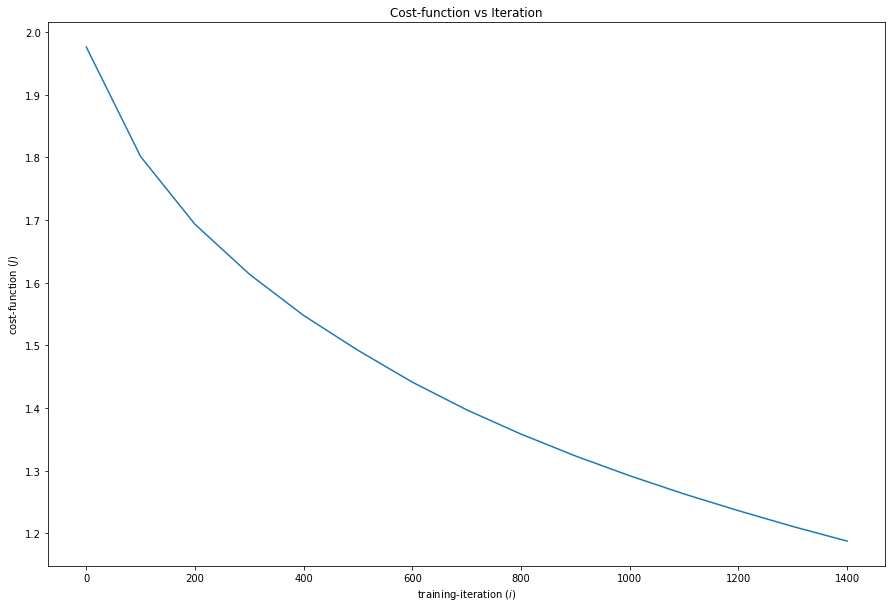

In [25]:
params, train_cache = model(layer_dims={25: 'relu',12: 'relu',6: 'softmax'}, 
        scaling_type='xavier', epochs=1500, batch_size=cu_train_X.shape[1], alpha=0.0001, 
        grad_scheme='batch',
        debug_mode=False, cache_per_iter=100)

## # batch gradient-descent
**Conclusions**: we can see that the cost fluctuates quite eratically, which is because of the eratic-stepping during gradient-descent.

Initializing parameters... {scaling-type: xavier, default-scale: 0.01}
.......................... {layers: {25: 'relu', 12: 'relu', 6: 'softmax'}}
Gradient-descent... {alpha: 0.0001, epochs: 1500}
................... {batch-size: 32}
................... {kwargs: {'scaling_type': 'xavier', 'grad_scheme': 'batch'}}


100%|██████████| 1500/1500 [05:23<00:00,  4.64it/s]


Train accuracy: 99.81481481481482%
Test accuracy: 89.16666666666667%


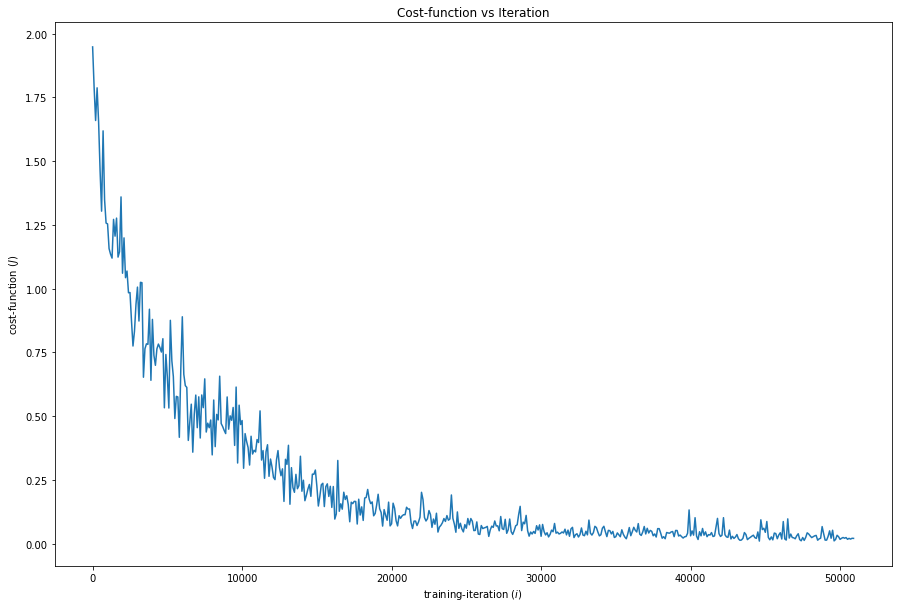

In [20]:
params, train_cache = model(layer_dims={25: 'relu',12: 'relu',6: 'softmax'}, 
        scaling_type='xavier', epochs=1500, batch_size=32, alpha=0.0001, 
        grad_scheme='batch',
        debug_mode=False, cache_per_iter=100)

## # momentum
**Conclusion**: compare the fluctuations in the cost to those when using "batch gradient-descent", they are lower! But compared to "rms-propagation" and "adam", it is still quite eratic.

Initializing parameters... {scaling-type: xavier, default-scale: 0.01}
.......................... {layers: {25: 'relu', 12: 'relu', 6: 'softmax'}}
Gradient-descent... {alpha: 0.0001, epochs: 500}
................... {batch-size: 32}
................... {kwargs: {'scaling_type': 'xavier', 'grad_scheme': 'momentum'}}


100%|██████████| 500/500 [01:55<00:00,  4.31it/s]


Train accuracy: 98.51851851851852%
Test accuracy: 85.83333333333333%


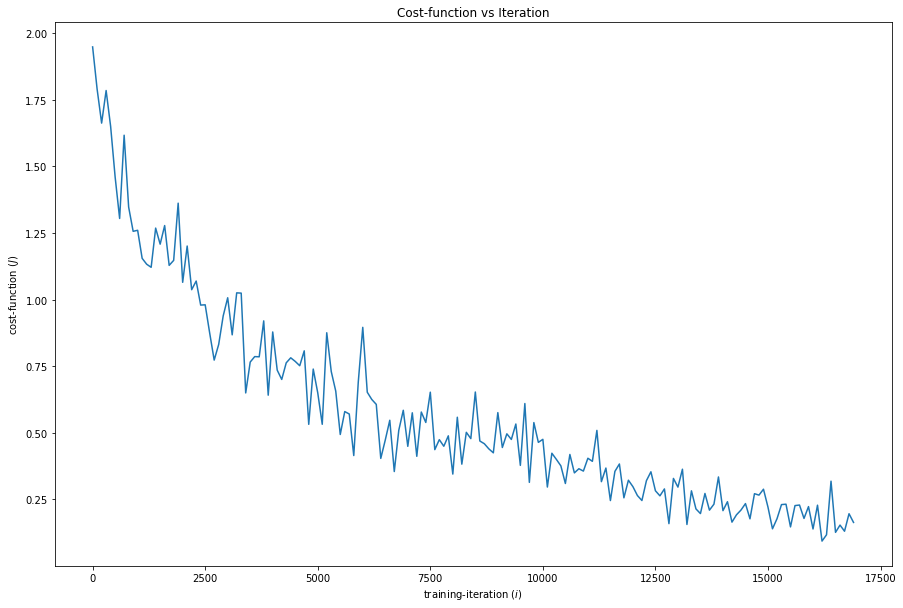

In [18]:
params, train_cache = model(layer_dims={25: 'relu',12: 'relu',6: 'softmax'}, 
        scaling_type='xavier', epochs=500, batch_size=32, alpha=0.0001, 
        grad_scheme='momentum',
        debug_mode=False, cache_per_iter=100)

## # rms-propagation
**Conclusin**: we can see that the stated accuracies are achieved with significantly fewer epochs.

Initializing parameters... {scaling-type: xavier, default-scale: 0.01}
.......................... {layers: {25: 'relu', 12: 'relu', 6: 'softmax'}}
Gradient-descent... {alpha: 0.0001, epochs: 500}
................... {batch-size: 32}
................... {kwargs: {'scaling_type': 'xavier', 'grad_scheme': 'rms-prop'}}


100%|██████████| 500/500 [02:06<00:00,  3.94it/s]


Train accuracy: 100.0%
Test accuracy: 90.0%


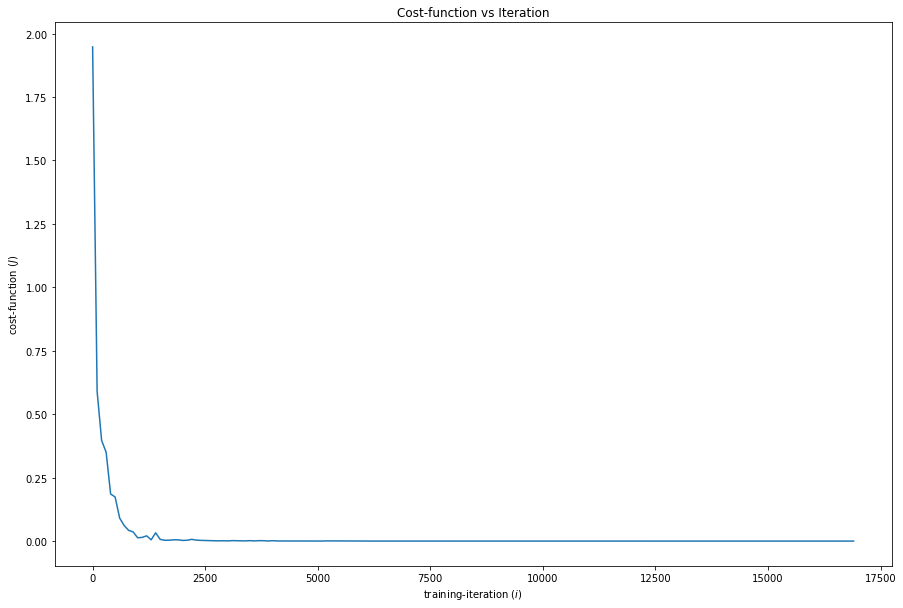

In [17]:
params, train_cache = model(layer_dims={25: 'relu',12: 'relu',6: 'softmax'}, 
        scaling_type='xavier', epochs=500, batch_size=32, alpha=0.0001, 
        grad_scheme='rms-prop',
        debug_mode=False, cache_per_iter=100)

## # adam
**Conclusions**: this optimizer achieves (slightly) higher accuracy compared to "rms-propagation", which in-turn is better than the rest of the methods.

Initializing parameters... {scaling-type: xavier, default-scale: 0.01}
.......................... {layers: {25: 'relu', 12: 'relu', 6: 'softmax'}}
Gradient-descent... {alpha: 0.0001, epochs: 500}
................... {batch-size: 32}
................... {kwargs: {'scaling_type': 'xavier', 'grad_scheme': 'adam'}}


100%|██████████| 500/500 [02:12<00:00,  3.78it/s]


Train accuracy: 100.0%
Test accuracy: 92.5%


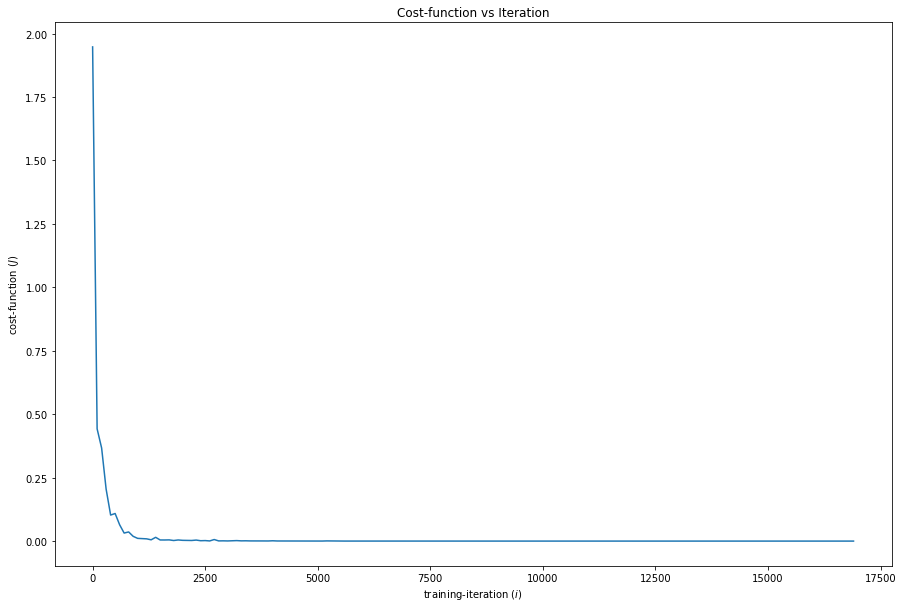

In [19]:
params, train_cache = model(layer_dims={25: 'relu',12: 'relu',6: 'softmax'}, 
        scaling_type='xavier', epochs=500, batch_size=32, alpha=0.0001, 
        grad_scheme='adam',
        debug_mode=False, cache_per_iter=100)